In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from pathlib import Path
import math
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

# Logistic regression+ Basic Features

In [2]:
QApair_df = pd.read_csv('train.csv')
QApair_df = shuffle(QApair_df)
QApair_df = QApair_df.dropna() #dropping na
QApair_df.head()

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
879,3602,198978,38298,why is pakistan denying the surgical strike,186810,what is the reason behind pakistan denying the...,51851,Because in war isn't that what the enemy is su...,1,1,1,2,3,45,74,8,13,6.0,20.0,0.300000
6619,5307,300387,243337,what would be your reaction if you discovered ...,243338,do you put money under your children s pillows...,226510,The Tooth Fairy brings magic (and money) to a ...,0,1,0,1,1,101,71,19,14,5.0,32.0,0.156250
7853,7807,192703,110216,how do i convert mp3 file to midi file,172955,is there a way to convert an audio file mp3 or...,146804,Bear File Converter.It helps you to convert Mp...,0,1,0,4,1,40,71,10,19,6.0,25.0,0.240000
1943,7720,200389,171871,is it possible the 2016 u s presidential elect...,171872,how is it possible to rig the 2016 election,146172,"Easy, just keep telling people over and over a...",1,1,1,1,1,98,45,19,10,9.0,23.0,0.391304
6485,5023,128745,394582,is google about to thrive or decline in the co...,62387,what year was google founded,24410,"Google was founded on 4th September, 1998.Google",0,1,0,1,1,58,30,12,6,2.0,18.0,0.111111


In [3]:
path_of_downloaded_bin = Path("C:\\Users\\ASUS\\NLP\\embeddings\\GoogleNews-vectors-negative300.bin")
word_vectors = KeyedVectors.load_word2vec_format(datapath(path_of_downloaded_bin), binary=True)

In [4]:
word_vec_dim = 300 # this number should match the embedding used
oov_vec = np.random.rand(word_vec_dim) 
def vectorize_sent(word_vectors, sent):
    word_vecs = []
    for token in word_tokenize(sent):
        if token not in word_vectors: 
            word_vecs.append(oov_vec)
        else:
            word_vecs.append(word_vectors[token].astype('float64'))
    return (np.mean(word_vecs,axis=0)).reshape(1,-1)


# ML with concatenated sentences

In [5]:
QApair_df["concat_text"] = QApair_df['qu']+' '+ QApair_df['qa'] #training data is cocatenated sentences
QApair_df = shuffle(QApair_df)
x_data = QApair_df["concat_text"]
y_data = QApair_df['is_duplicate'] #list of labels

print("length of x_data:",len(x_data))
print("length of y_data:",len(y_data))

length of x_data: 8000
length of y_data: 8000


In [6]:
x_data_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in x_data]) #vector of concatenated questions
x_data_vecs = x_data_vecs.reshape(len(x_data),word_vec_dim) #reshaping the array from 3d to 2d

In [7]:
clf = LogisticRegression(C = 1.0,class_weight = 'dict', max_iter = 1000,solver = 'newton-cg').fit(x_data_vecs, y_data)

In [8]:
#finding mean reciprocal rank:
test_df_ml = pd.read_csv('test.csv') #getting the test data
test_df_ml = test_df_ml[['qu','qa','is_duplicate']].copy()
test_df_ml = test_df_ml[:500]
l = len(test_df_ml['qa'])#Number of archived Questions
print("Number of archived Questions:",l)

Number of archived Questions: 500


In [9]:
user_questions = test_df_ml['qu'].tolist()
concat_reciprocal_rank_list = []
arch_questions = test_df_ml['qa'].tolist()
l = len(arch_questions)
for uquest_id, user_quest in enumerate(user_questions):
    most_similar_quest_id = 0
    test_ml = test_df_ml[['qa']].copy()
    test_ml['qu'] = [user_quest]*l
    test_ml['concat_text'] = test_ml['qu']+' '+ test_ml['qa']
    test_x_data = test_ml["concat_text"]
    test_xdata_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_x_data.tolist()])
    test_xdata_vecs = test_xdata_vecs.reshape(len(arch_questions),word_vec_dim)
    y_pred = clf.predict_proba(test_xdata_vecs) #predict probability
    y_max = y_pred[:,0] #selecting only probability of duplication
    most_similar_quest_id = np.argmax(np.array(y_max))
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        concat_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        concat_reciprocal_rank_list.append(0)


In [10]:
concat_mean_reciprocal_rank = np.mean(np.array(concat_reciprocal_rank_list))
print("Mean Reciprocal Rank for ML+Cosine similiarity ",concat_mean_reciprocal_rank)
print("Number of question correctly retreived for Bert Embedding: ", sum(concat_reciprocal_rank_list) )

Mean Reciprocal Rank for ML+Cosine similiarity  0.0
Number of question correctly retreived for Bert Embedding:  0


# ML+Word Embeddings Difference

In [11]:
all_text = QApair_df[["qu","qa"]]
all_labels = QApair_df["is_duplicate"]
print("all text size", len(all_text))
print("All label size", len(all_labels))

all text size 8000
All label size 8000


In [12]:
all_user_text = all_text["qu"].tolist()
all_arch_text = all_text["qa"].tolist()

In [13]:
#following embeddingds are used for finding diff distances between question pairs of all vectors
all_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_user_text]) #getting vector representation for user questions
all_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_arch_text]) #getting vector representation for archived questions

In [14]:
x_data = all_user_vecs-all_arch_vecs
x_data = x_data.reshape(len(all_user_text),word_vec_dim)
y_data = all_labels

In [15]:
clf = LogisticRegression(C = 1.0,class_weight = 'dict',max_iter  = 1000,solver = 'sag').fit(x_data, y_data)

In [16]:
#finding mean reciprocal rank:
test_df_ml = pd.read_csv('test.csv') #getting the test data
test_df_ml = test_df_ml[['qu','qa','is_duplicate']].copy()
test_df_ml = test_df_ml[:500]
l = len(test_df_ml['qa'])#Number of archived Questions
print("Number of archived Questions:",l)

Number of archived Questions: 500


In [17]:
diff_reciprocal_rank_list = []
most_similar_quest_id = 0
user_questions = test_df_ml['qu'].tolist()
arch_questions = test_df_ml['qa'].tolist()
test_user_vecs_ml = np.array([vectorize_sent(word_vectors, ss) for ss in user_questions]) #getting vector representation for user questions
test_arch_vecs_ml = np.array([vectorize_sent(word_vectors, ss) for ss in arch_questions]) #getting vector representation for archived questions
for uquest_id, user_quest in enumerate(test_user_vecs_ml):
    user_vecs = np.array([user_quest]*l) #making the dimesion of user vecs same as arch vecs
    test_x_data = user_vecs-test_arch_vecs_ml #finding difference between user question vectors and archived question 
    test_x_data = test_x_data.reshape(l,word_vec_dim)
    y_pred = clf.predict_proba(test_x_data) #predict probability
    y_max = y_pred[:,1] #selecting only probability of duplication
    most_similar_quest_id = np.argmax(np.array(y_max))
    most_similar_quest_id
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        diff_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        diff_reciprocal_rank_list.append(0)


In [18]:
diff_mean_reciprocal_rank = np.mean(np.array(diff_reciprocal_rank_list))
print("Mean Reciprocal Rank for Ml+diff of embeddings ",diff_mean_reciprocal_rank)
print("Number of question correctly retreived for Ml+diff of embeddings: ", sum(diff_reciprocal_rank_list) )

Mean Reciprocal Rank for Ml+diff of embeddings  0.002
Number of question correctly retreived for Ml+diff of embeddings:  1


In [19]:
results_df = pd.DataFrame()
results_df["Method"] = ["LR+ConcatQuestions","LR+Difference of vectors"]
results_df["mean_reciprocal_ranks"] = [concat_mean_reciprocal_rank,diff_mean_reciprocal_rank]
results_df

,Method,mean_reciprocal_ranks
0,LR+ConcatQuestions,0.000
1,LR+Difference of vectors,0.002


([0, 1], [Text(0, 0, ''), Text(0, 0, '')])

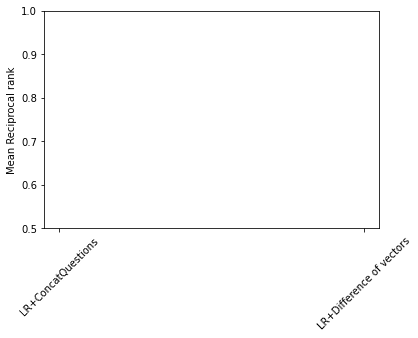

In [20]:
import matplotlib.pyplot as plt
plt.plot(results_df["Method"],results_df["mean_reciprocal_ranks"])
plt.ylabel("Mean Reciprocal rank")
plt.ylim(0.5,1)
plt.xticks(rotation = 45)